<IPython.core.display.Javascript object>


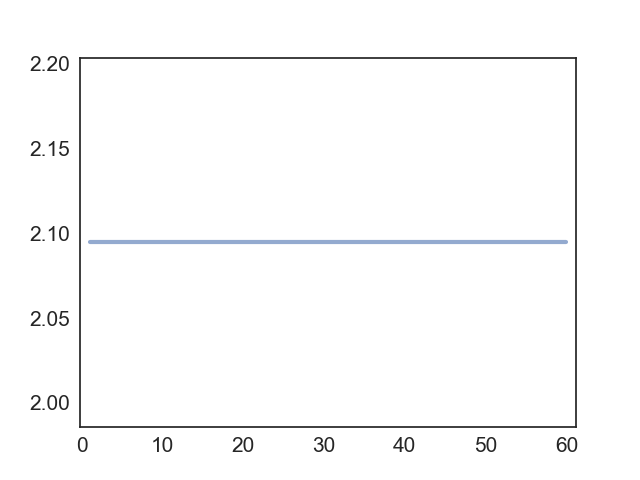

In [13]:
%matplotlib notebook

from modsim import *
import numpy as np
# Average statistics.
# Grams of ethanol consumed.
alcohol_consumed = 15
# Absorption rate constant. 3.18 is mean blood value.
k = 3.18
# BAC. .04 is the legal driving limit, though you should never drink and drive!
BAC = .04 
# Elimination rate constant. .163 is mean blood value.
beta = .163
# Body fat ratio. .67 for men, .73 men.
ratio = .73
def absorb_alcohol(d, t):
    """
    Returns the amount of alcohol absorbed.
    """
    return (d * (1-np.e**(-k*t)))/ratio*50

def eliminate_alcohol(t):
    """
    Returns the amount of alcohol eliminated
    """
    return beta * t

def model_alcohol_processing(d, t):
    """
    Simulates alcohol processing with a timeseries.
    TODO this is currently untested but pushing anyways.
    """
    result = TimeSeries()
    for m in linrange(0, t):
        result[m] = absorb_alcohol(d, m) - eliminate_alcohol(d, m)
        
#plot(model_alcohol_processing(15, 60))
def weight_based_on_bac(t, input_BAC):
    """
    Returns the weight of the individual based on static BAC and time.
    """
    return (alcohol_consumed*(1-np.e**(-k*t)))/((input_BAC + beta*t)*ratio)

def BAC_based_on_weight(t, input_weight):
    """
    Returns the BAC of the individual based on static weight and time.
    """
    # TODO Solve for BAC here
    pass


# What we can do is we can keep the BAC of an individual constant. Then, we can substitute in different weights and try to level 
# out the BAC and make some interesting plots while we're at it.

t = linrange(1, 60)
h = 60
plot(t, weight_based_on_bac(60, .03))